In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.model_selection import KFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../assests/scaled_voice_data.csv')

In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,kurt,sp.ent,sfm,mode,meanfun,minfun,modindx,gender
0,0.053833,0.182412,-0.043344,-0.211354,0.539997,0.538854,-0.240888,0.835319,-0.042416,0.207412,-0.837226,0.540973,-0.366495,male
1,-1.948336,1.299573,-2.059818,-1.855442,-0.519379,1.824196,0.163259,1.025120,1.077412,-2.141210,-1.247501,-1.089900,0.159773,male
2,0.646042,0.495259,0.871554,0.640148,1.145548,-0.095419,-0.201828,0.608758,0.670084,0.694611,0.648140,0.567828,-0.761240,female
3,0.676572,-0.985618,0.417501,0.876052,-0.107268,-1.056066,-0.218332,-0.515259,-0.533573,0.230766,0.775463,0.602869,-0.112419,female
4,0.945822,-0.909062,0.667029,1.041938,0.402815,-0.962975,-0.219860,-0.715600,-0.588908,0.517069,0.611636,0.652038,-0.295663,female


In [6]:
x = df.drop('gender',axis=1)
y = df['gender']

In [7]:
x.head()

,meanfreq,sd,median,Q25,Q75,IQR,kurt,sp.ent,sfm,mode,meanfun,minfun,modindx
0,0.053833,0.182412,-0.043344,-0.211354,0.539997,0.538854,-0.240888,0.835319,-0.042416,0.207412,-0.837226,0.540973,-0.366495
1,-1.948336,1.299573,-2.059818,-1.855442,-0.519379,1.824196,0.163259,1.025120,1.077412,-2.141210,-1.247501,-1.089900,0.159773
2,0.646042,0.495259,0.871554,0.640148,1.145548,-0.095419,-0.201828,0.608758,0.670084,0.694611,0.648140,0.567828,-0.761240
3,0.676572,-0.985618,0.417501,0.876052,-0.107268,-1.056066,-0.218332,-0.515259,-0.533573,0.230766,0.775463,0.602869,-0.112419
4,0.945822,-0.909062,0.667029,1.041938,0.402815,-0.962975,-0.219860,-0.715600,-0.588908,0.517069,0.611636,0.652038,-0.295663


In [8]:
y.head()

0      male
1      male
2    female
3    female
4    female
Name: gender, dtype: object

### Perform K-Cross Validation for k = 10

Logistic regression model

In [9]:
def perform_logistic_regression(x_train, y_train, x_test, y_test, i, k, display_stats=False):
    log_reg_model = LogisticRegression(penalty='l2', max_iter=500)
    log_reg_model.fit(x_train, y_train)
    y_pred = log_reg_model.predict(x_test)

    # Accuracy, Precision, Recall, F1-score of Model
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

    if display_stats:
        print(f"Statistics for Fold {i} in K-fold (k={k}) 'Logistic Regression' algorithm")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1_score}")
        print()

    return np.array([accuracy, precision, recall, f1_score])

Perform K-corss validation

In [10]:
k = 10
i = 0
k_fold = KFold(n_splits=k)

# Holds Mean of {accuracy, precision, recall, f1_score}
mean_stats = np.zeros(4)

for train_index, test_index in k_fold.split(x):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    stats = perform_logistic_regression(x_train, y_train, x_test, y_test, i:=i+1, k, display_stats=False)
    mean_stats = mean_stats + stats
    
# Take mean of {accuracy, precision, recall, f1_score}
mean_stats = mean_stats / k

print(f"Mean accuracy: {mean_stats[0]*100}")
print(f"Mean Precision: {mean_stats[1]*100}")
print(f"Mean Recall: {mean_stats[2]*100}")
print(f"MeanF1-score: {mean_stats[3]*100}")

Mean accuracy: 97.25422273689256
Mean Precision: 97.27349391570598
Mean Recall: 97.25422273689256
MeanF1-score: 97.2549929174447


## ROC-AUC Curve for Logistic Regression

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [12]:
le = LabelEncoder()
Y_encoded = le.fit_transform(y)

In [13]:
xtrain_roc, xtest_roc, ytrain_roc, ytest_roc = train_test_split(x, Y_encoded, test_size=0.2)

In [14]:
def roc_auc(y_test, y_pred):
    fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,8))
    lisrt=['male','female']
    for m in range(2):
        ls=[]
        for j in y_test:
            if m==j:
                ls.append(1)
            else:
                ls.append(0)

        fpr, tpr, thresh =  metrics.roc_curve(ls,y_pred[:,m])
        auc = metrics.roc_auc_score(ls,y_pred[:,m])
        axes[m].plot(fpr, tpr,  label="AUC = " +str(auc), linestyle='--',color='red')
        axes[m].set_title(f'ROC-AUC curve for class {lisrt[m]}')
        axes[m].set_xlabel('False Positive Rate')
        axes[m].set_ylabel('True Positive rate')
        axes[m].legend(lisrt[m])
        axes[m].text(0.5,0.0, f'AUC value :{auc}')
        plt.savefig('images/ROC-AUC_Logistic_regression.png',dpi=300)
        plt.tight_layout()

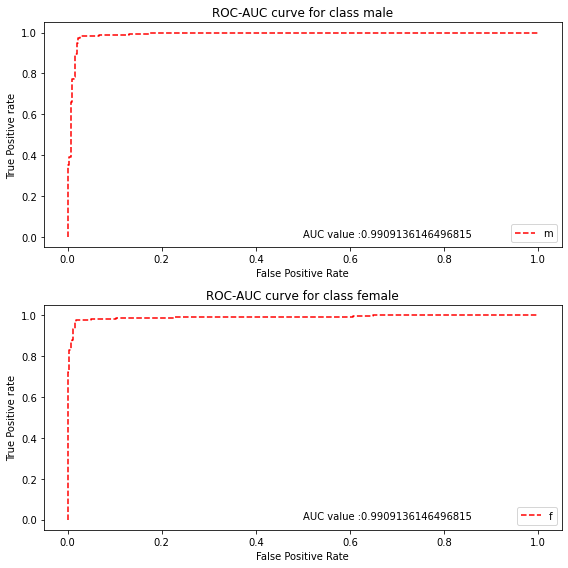

In [15]:
log_reg_model = LogisticRegression(penalty='l2', max_iter=500)
log_reg_model.fit(xtrain_roc, ytrain_roc)
ypred_roc = log_reg_model.predict_proba(xtest_roc)

roc_auc(ytest_roc, ypred_roc)